In [180]:
import numpy as np
import torch

from tqdm import tqdm
from matplotlib import pyplot as plt

import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
# If GPUs available, select which to train on
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [182]:
score = np.load('./data/band_score.npy')
ratemap = np.load('./data/rate_map.npy')
activations_theta = np.load('./data/activations_theta.npy')

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as nf
from scipy.optimize import curve_fit
from tqdm import tqdm


def band_score(rate,res):
    X,Y = np.meshgrid(np.linspace(-2,2,res),np.linspace(-2,2,res))
    x_flat,y_flat = X.flatten(), Y.flatten()
    loc = np.stack([x_flat,y_flat])

    # 计算频谱
    def spectrum(ratemap):
        res = ratemap.shape[0]
        fft_rate = np.abs(nf.fftshift(nf.fft2(ratemap)))
        fft_rate[:int(res/2),:] = 0
        return fft_rate
    ratemap = rate.reshape(res,res)
    fft_rate = spectrum(ratemap)

    # 定义高斯函数
    def gaussian(loc, A, k, phi, sigma):
        x = loc[0]
        y = loc[1]
        return A * np.exp(-((x - k*np.cos(phi))**2 / (2 * sigma**2) + (y - k*np.sin(phi))**2 / (2 * sigma**2)))

    initial_guess = [1.0, 0.2, 0.0, 0.1]

    try:
        params, _ = curve_fit(lambda xy, A, k, phi, sigma: gaussian(xy, A, k, phi, sigma), 
                                (loc), 
                                fft_rate.ravel(), 
                                p0=initial_guess, 
                                bounds=([0, 0.2, 0, 0.05], [np.inf, 1, np.pi, 0.5]),
                                maxfev=1000)  # 增加最大函数评估次数
    except RuntimeError as e:
        # print("Warning:", e)
        # 使用 `full_output=True` 调用 leastsq 获取最后一步的参数
        from scipy.optimize import leastsq
        params, _, _, _, _ = leastsq(
            lambda xy: fft_rate.ravel() - gaussian(loc, *xy), initial_guess or np.ones(len(initial_guess)), full_output=True, maxfev=1000
        )
        # print("Returning last known parameters:", params)
    # return popt, pcov
    dx = 4/res
    k0 = params[1]
    phi = params[2]
    sigma = params[3]
    kx = k0*np.cos(phi)/2*(1/dx/2)*np.pi*2
    ky = k0*np.sin(phi)/2*(1/dx/2)*np.pi*2
    k = np.sqrt(kx**2+ky**2)# The maximum frequency is 1/dx, correspoding k = np.pi*2/dx
    l = np.pi*2/k
    # print(params)
    gx = gaussian(loc, params[0], params[1], params[2], params[3])

    # 计算相关性
    band_scores = np.dot(fft_rate.ravel(), gx.ravel()) / (1e-8+np.linalg.norm(fft_rate.ravel()) * np.linalg.norm(gx.ravel())) / sigma

    return band_scores, ratemap, l


res = 50

data = np.load('./data/rate_map.npy')
print(data.shape)
Ng = data.shape[0]
T = data.shape[1]
score = np.zeros(Ng,)
l = np.zeros(Ng,)
ratemap = np.zeros([Ng,50,50])
for i in tqdm(range(Ng)):
    rate = data[i]-np.mean(data[i])
    band_scores, rm,l[i] = band_score(rate,res)
    ratemap[i] = rm
    score[i] = band_scores

(4096, 2500)


100%|██████████| 4096/4096 [00:48<00:00, 83.60it/s] 


Text(0.5, 1.0, 'band score distribution')

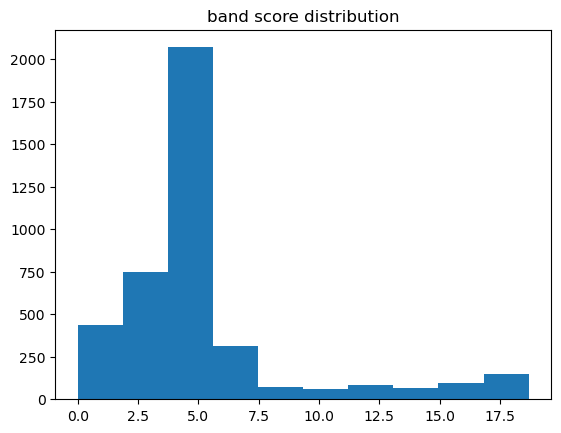

In [184]:
plt.hist(score)
plt.title('band score distribution')

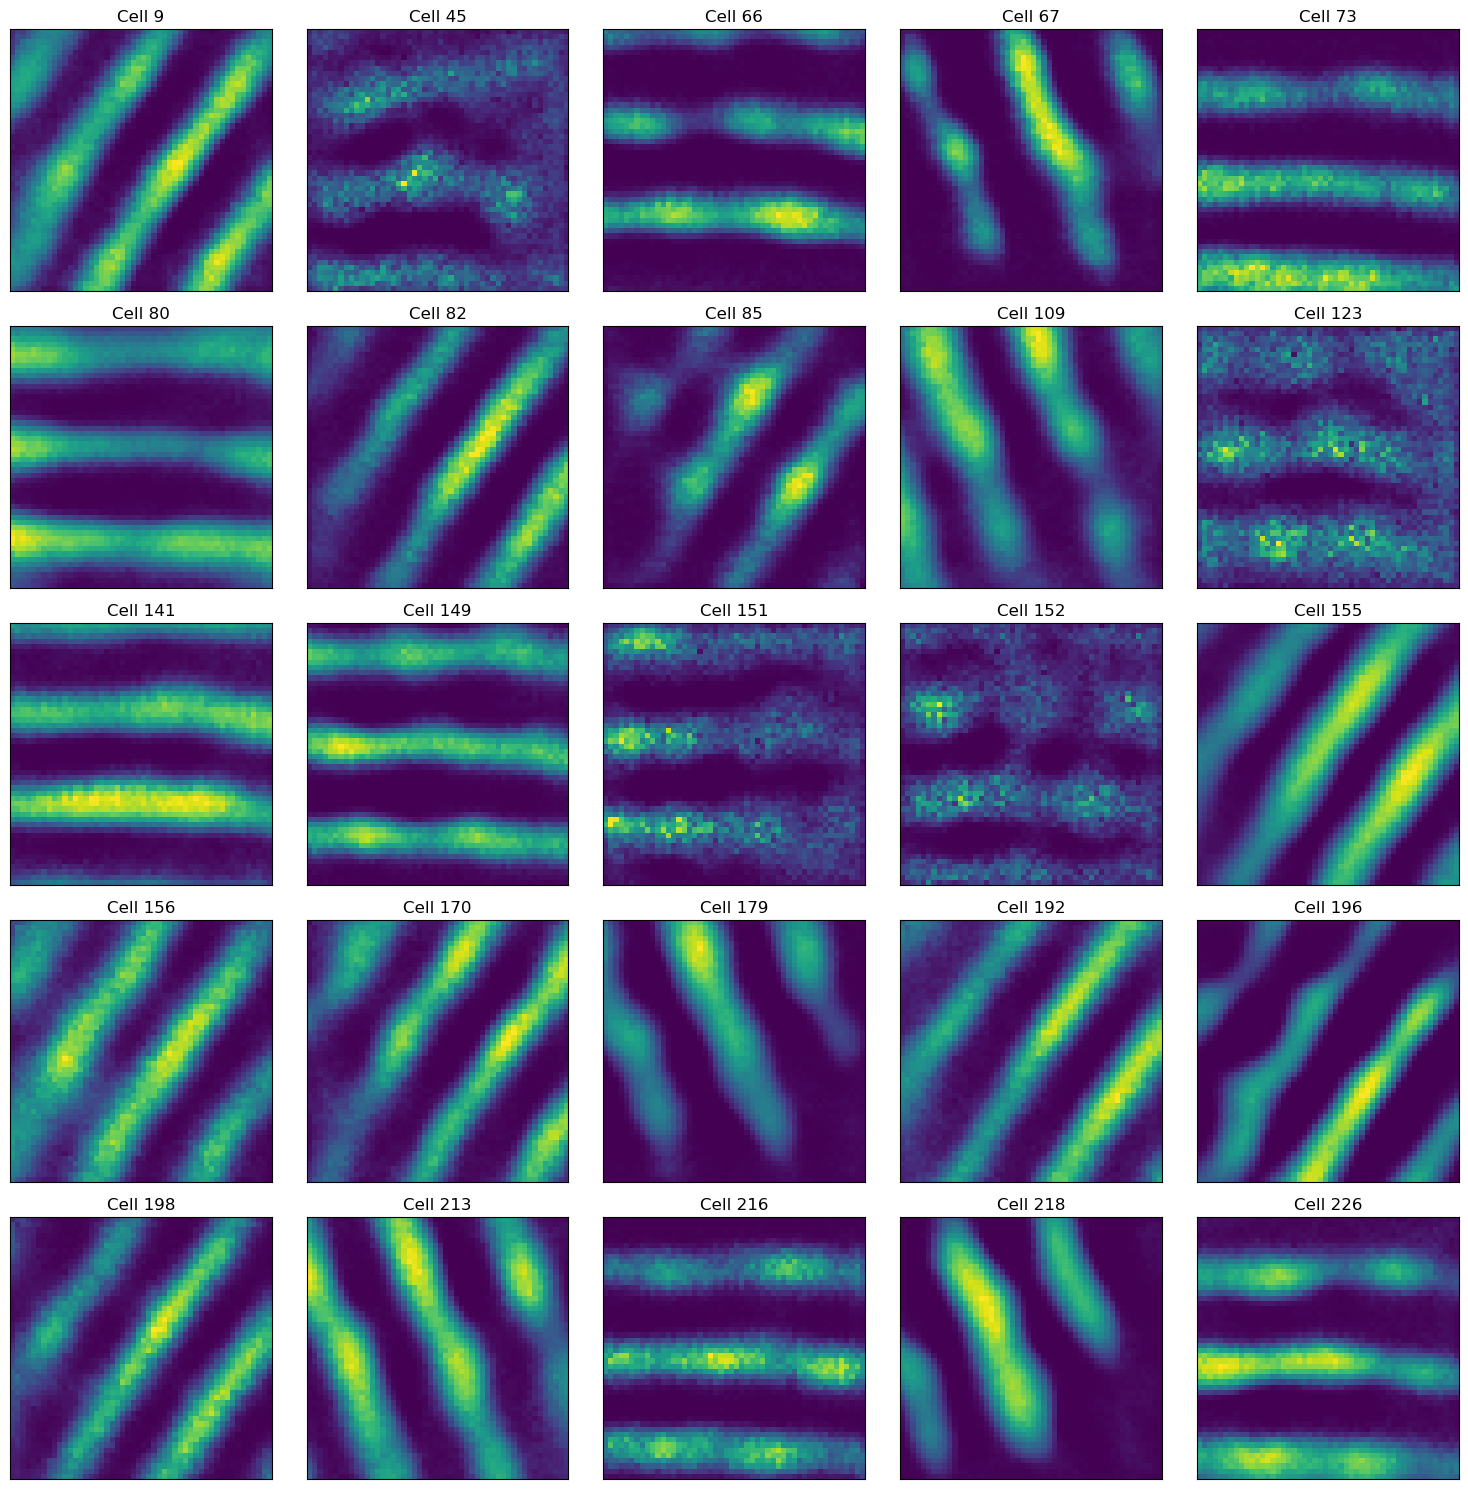

In [185]:
index_band = np.where(score>10)[0]

n_sub = 5
fig, ax = plt.subplots(n_sub, n_sub, figsize=(15, 15))

theta = np.linspace(-np.pi, np.pi, res * 2)

# print(len(index_band))
for i in range(n_sub**2):
    x = i // n_sub
    y = i % n_sub
    ax[x, y].set_title(f'Cell {index_band[i]}')
    ax[x,y].imshow(ratemap[index_band[i]])
    ax[x, y].set_xticks([])  # Remove x-axis ticks
    ax[x, y].set_yticks([])  # Remove y-axis ticks
    ax[x, y].tick_params(axis='both', which='both', length=0) 

plt.tight_layout()

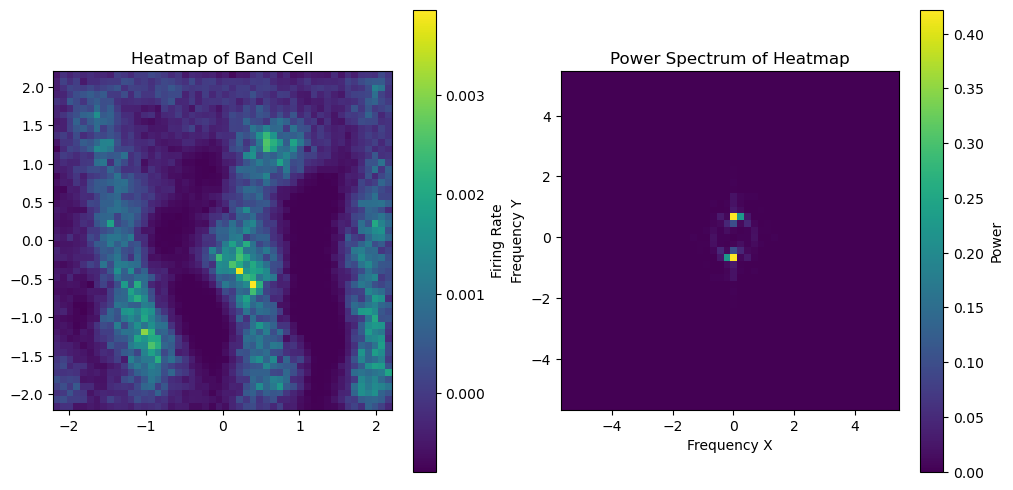

Average Orientation: -5.07038230047415 degrees


In [193]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_band_cell_orientation_and_periodicity(heatmap, res, space_range=(-2.2, 2.2), plot=False):
    # 计算空间步长
    space_extent = space_range[1] - space_range[0]
    dx = space_extent / res
    
    # 计算傅立叶变换
    fft_result = np.fft.fftshift(np.fft.fft2(heatmap))
    power_spectrum = np.abs(fft_result) ** 2
    # power_spectrum = np.where(power_spectrum>200,power_spectrum,0)

    # 获取频率坐标
    freq = np.fft.fftfreq(res, d=dx)
    freq_shifted = np.fft.fftshift(freq)
    X, Y = np.meshgrid(freq_shifted, freq_shifted)
    
    # 计算每个频率分量的方向角
    orientations = np.arctan2(Y, X)
    orientations = np.where(orientations >= 0, orientations, orientations + np.pi)  # 限制在 0 到 π 之间
    
    
    # 计算加权平均方向角（考虑到旋转 π 的对称性）
    weighted_orientations = power_spectrum * np.exp(1j * 2 * orientations)
    avg_orientation = np.angle(np.sum(weighted_orientations))  # 平均方向角
    avg_orientation = avg_orientation  + np.pi  # 确保在 0 到 π 之间
    avg_orientation = avg_orientation/2
    avg_orientation = np.where(avg_orientation >= 170/180*np.pi, avg_orientation-np.pi, avg_orientation) 

    if plot:
        # 绘制原始heatmap和频谱
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(heatmap.T, extent=(space_range[0], space_range[1], space_range[0], space_range[1]), origin="lower")
        plt.title("Heatmap of Band Cell")
        plt.colorbar(label="Firing Rate")

        plt.subplot(1, 2, 2)
        plt.imshow(power_spectrum, extent=(freq_shifted[0], freq_shifted[-1], freq_shifted[0], freq_shifted[-1]), origin="lower")
        plt.title("Power Spectrum of Heatmap")
        plt.colorbar(label="Power")
        plt.xlabel("Frequency X")
        plt.ylabel("Frequency Y")

        plt.show()

    return avg_orientation * (180 / np.pi)

# 假设 heatmap 是一个 res x res 大小的矩阵，填充示例数据
rate_map = ratemap[index_band[1]]
orientation = analyze_band_cell_orientation_and_periodicity(rate_map, 50, plot=True)
print(f"Average Orientation: {orientation} degrees")


100%|██████████| 438/438 [00:00<00:00, 2042.25it/s]


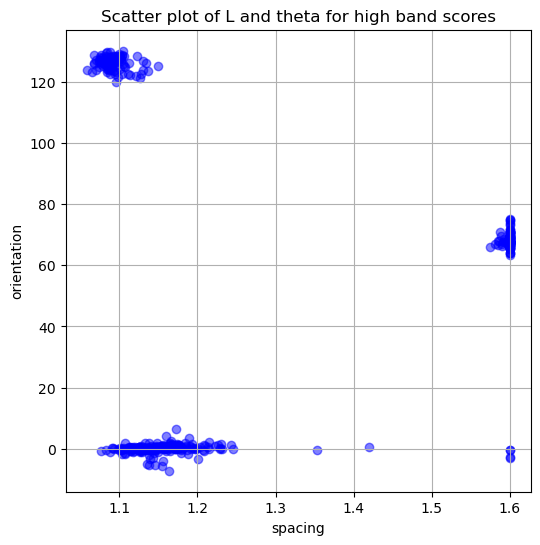

[ 1.27107497e+02 -5.07038230e+00  1.22461577e+00  6.57846099e+01
  5.64235854e-01 -4.12487405e-01  1.24019168e+02  1.23469301e+02
  6.79048393e+01  3.39797222e+00  8.24915050e-02  4.63147259e-01
  1.33506301e-01 -1.98269693e+00  1.25159598e+02  1.24984370e+02
  1.23798959e+02  6.59655092e+01  1.26626552e+02  1.28497105e+02
  1.25913753e+02  6.82341130e+01  4.90426994e-01  7.04946627e+01
 -2.84429478e-01  1.28227106e+02 -6.37372508e-01  2.04280484e-01
  6.93623726e+01  2.24362761e-01  6.23422893e-02  2.11638435e-01
  1.25368027e+02  1.28108210e+02  1.23253849e+02  1.28771974e+02
 -1.65099957e-01 -6.02443857e-01 -5.22236162e+00 -1.45201127e-01
  1.25988065e+02  1.27837827e+02  1.26390623e+02  1.95126638e+00
  8.21642002e-01  7.08518084e+01  6.79132621e+01  6.79103643e+01
  6.77280746e+01  1.83184791e+00  6.69918795e+01  4.19290163e-01
 -2.17831728e-01 -1.75380597e+00  1.26697255e+02 -3.40782296e+00
  3.03649680e-01  1.28760950e+02  1.26186800e+02  1.26815942e+02
 -1.13758043e-01  6.89918

In [195]:
#### gamma represents the orientation of the band cells, l represents the spacing
N_band = index_band.shape[0]
gamma = np.zeros(N_band)
for i in tqdm(range(N_band)):
    gamma[i] = analyze_band_cell_orientation_and_periodicity(ratemap[index_band[i]], 50)

plt.figure(figsize=(6, 6))
plt.scatter(l[index_band], gamma, c='blue', alpha=0.5)
plt.xlabel('spacing')
plt.ylabel('orientation')
plt.title('Scatter plot of L and theta for high band scores')
plt.grid(True)
plt.show()
print(gamma)
    